# Time Series Modelling 2 - ARIMA model

In [1]:
from __future__ import print_function
import numpy as np
import pandas as pd
import seaborn as sns
import pandas.testing as tm
from pandas import DataFrame
import matplotlib as plt
from matplotlib import pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
import statsmodels.tsa.api as smtsa

from pmdarima.arima import auto_arima 
# !! warning  pmdarima might be uncompatible with certain python packages, especially numpy
# the newest version claims to be compatible only with numpy version 1.19.0
# However, the numpy version I have run here was: 1.20.3


# Data preprocessing phase

In this phase similar to the previous notebook, the required information is extracted and subsetted from the original dataset. The number of infected people is transformed and aggregated to daily sums. 

In [2]:
dutch_data_01 = pd.read_csv('/Users/stevenkraamwinkel/Desktop/Datasets 1 mei/COVID-19_aantallen_gemeente_cumulatief_01_05.csv', parse_dates=True, delimiter=';')
display(dutch_data_01)


,Date_of_report,Municipality_code,Municipality_name,Province,Total_reported,Hospital_admission,Deceased
0,13/03/2020 10:00,GM0003,Appingedam,Groningen,0,0,0
1,13/03/2020 10:00,GM0010,Delfzijl,Groningen,0,0,0
2,13/03/2020 10:00,GM0014,Groningen,Groningen,3,0,0
3,13/03/2020 10:00,GM0024,Loppersum,Groningen,0,0,0
4,13/03/2020 10:00,GM0034,Almere,Flevoland,1,1,0
...,...,...,...,...,...,...,...
151955,01/05/2021 10:00,NaN,NaN,Noord-Holland,668,20,2
151956,01/05/2021 10:00,NaN,NaN,Zuid-Holland,2312,46,15
151957,01/05/2021 10:00,NaN,NaN,Zeeland,56,4,1
151958,01/05/2021 10:00,NaN,NaN,Noord-Brabant,1144,29,7


In [3]:
#Selecting columns
dutch_data_01 = dutch_data_01[['Date_of_report', 'Total_reported', 'Hospital_admission', 'Deceased']]
dutch_data_01['Date_of_report']= pd.to_datetime(dutch_data_01['Date_of_report'], format='%d/%m/%Y %H:%M')
dutch_data_01 = dutch_data_01.set_index('Date_of_report')

dutch_data_01.loc[dutch_data_01.index!='Date_of_report'].sum()
dutch_data_01 = dutch_data_01.resample('D').sum()
display(dutch_data_01)


,Total_reported,Hospital_admission,Deceased
Date_of_report,,,
2020-03-13,804,115,9
2020-03-14,959,136,12
2020-03-15,1135,162,19
2020-03-16,1413,205,23
2020-03-17,1705,314,40
...,...,...,...
2021-04-27,1472674,28445,17093
2021-04-28,1481323,28517,17104
2021-04-29,1488594,28580,17124


In [4]:
all_covid_nl_values = dutch_data_01[['Total_reported', 'Hospital_admission', 'Deceased']]
all_covid_nl_values = all_covid_nl_values.diff()

#Selecting months april 2020 - april 2021
all_covid_nl_values = all_covid_nl_values['2020-04-01':'2021-04-30']
all_covid_infections = all_covid_nl_values['Total_reported']

display(all_covid_infections)
all_covid_infections.dtypes

Date_of_report
2020-04-01    1019.0
2020-04-02    1083.0
2020-04-03    1026.0
2020-04-04     904.0
2020-04-05    1224.0
               ...  
2021-04-26    6200.0
2021-04-27    5337.0
2021-04-28    8649.0
2021-04-29    7271.0
2021-04-30    7758.0
Freq: D, Name: Total_reported, Length: 395, dtype: float64

dtype('float64')

## Data plots and ADF-analysis on Total reported corona infections

To understand to underlying data patterns better, and to determine the order of the ARIMA(p,d,q) model it is very beneficial to plot the data first. 
Data plots that capture times series data best are: the run sequence plot, lag plot, QQ-plot, ACF plot, and PACF plot. 

/Users/stevenkraamwinkel/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


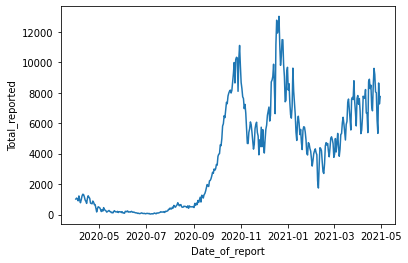

In [5]:
#Seaborn run sequence plot (line plot)

all_covid_infections = all_covid_infections.reset_index()

#displaying daily COVID-19 positive tests over the time interval april 2020 - april 2021

x = all_covid_infections.Date_of_report
y = all_covid_infections.Total_reported
lineplot = sns.lineplot(x, y)


In [6]:
all_covid_nl_values = dutch_data_01[['Total_reported', 'Hospital_admission', 'Deceased']]
all_covid_nl_values = all_covid_nl_values.diff()

#Selecting months april 2020 - april 2021
all_covid_nl_values = all_covid_nl_values['2020-04-01':'2021-04-30']
all_covid_infections = all_covid_nl_values['Total_reported']
display(all_covid_infections)

Date_of_report
2020-04-01    1019.0
2020-04-02    1083.0
2020-04-03    1026.0
2020-04-04     904.0
2020-04-05    1224.0
               ...  
2021-04-26    6200.0
2021-04-27    5337.0
2021-04-28    8649.0
2021-04-29    7271.0
2021-04-30    7758.0
Freq: D, Name: Total_reported, Length: 395, dtype: float64

In [7]:
# The following function and codes were modified from source:
# Practical Time Series Analysis, Master Time Series Data Processing, Visualisation,
# and Modeling using Python - Dr. Avishek Pal, PKS Prakash
# Tutorial E-book

### Lag-plot

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

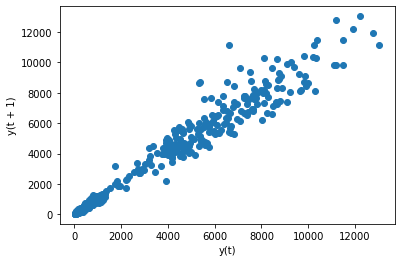

In [8]:
pd.plotting.lag_plot(all_covid_infections, lag=1)

### QQ-plot

/Users/stevenkraamwinkel/opt/anaconda3/lib/python3.7/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


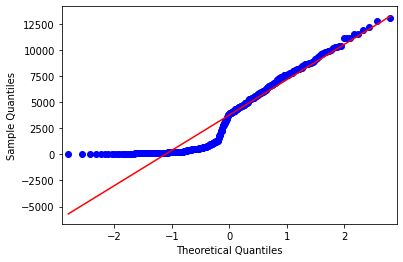

In [9]:
# QQ plot and probability plot
sm.qqplot(all_covid_infections, line='s');

### Run sequence,  ACF and PACF plot

In [10]:
# Function to plot run sequence, ACF and PACF
def plotds(xt, nlag=30, fig_size=(12, 10)):
    if not isinstance(xt, pd.Series):
         xt = pd.Series(xt)
    plt.figure(figsize=fig_size)
    layout = (2, 2)
    
    # Assign axes
    ax_xt = plt.subplot2grid(layout, (0, 0), colspan=2)
    ax_acf= plt.subplot2grid(layout, (1, 0))
    ax_pacf = plt.subplot2grid(layout, (1, 1))
    
    # Plot graphs
    xt.plot(ax=ax_xt)
    ax_xt.set_title('Time Series Run Sequence')
    plot_acf(xt, lags=100, ax=ax_acf)
    plot_pacf(xt, lags=100, ax=ax_pacf)
    plt.tight_layout()
    return None

/Users/stevenkraamwinkel/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/Users/stevenkraamwinkel/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


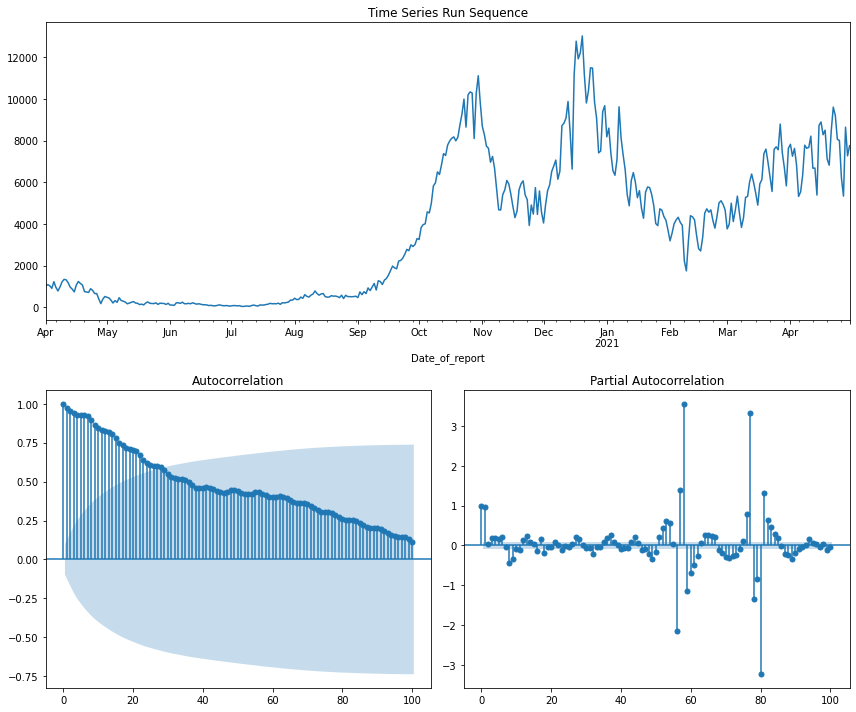

In [11]:
# Plot Run sequence, ACF and PACF plot 
all_covid_infections = all_covid_infections.dropna()
plotds(all_covid_infections, nlag=50)


### ADF test

The ADF test is a statistical test to determine if the data needs differentiation before being modelled into an ARIMA model. In other words, the differencing parameter nees to be determined, and being set at an positive integer value > 0 or not. When the ADF test statistic is greater than 0.05 the data can be considered as non-stationary, and the differencing parameter, d, in the ARIMA(p, d, q) model needs to be set at least at 1. 

In [12]:
# ADF Test
from statsmodels.tsa.stattools import adfuller
adf_result= adfuller(all_covid_infections.tolist())
print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])

ADF Statistic: -1.864142
p-value: 0.349113


Since the p-value of the input data for the ARIMA model is non-stationary, differencing is required. The differencing factor needs to be at an whole integer value of at least 1. 

## ARIMA model, hyperparameter tuning

Since the ARIMA model has three parameters, which in most cases can be set at any zero or positive integer value from 1 to 5, manually trying all combinations is very infeasible. 
However, the auto_arima function from the pmdarima package can compute different model combinations, and can determine the best set of p, d, q parameters for any ARIMA model. 

In [14]:
#Split the data into train and test set
train = all_covid_infections[0:306]
test = all_covid_infections[306:]

display(all_covid_infections)

Date_of_report
2020-04-01    1019.0
2020-04-02    1083.0
2020-04-03    1026.0
2020-04-04     904.0
2020-04-05    1224.0
               ...  
2021-04-26    6200.0
2021-04-27    5337.0
2021-04-28    8649.0
2021-04-29    7271.0
2021-04-30    7758.0
Freq: D, Name: Total_reported, Length: 395, dtype: float64

In [15]:
#Hyper parameter tuning
#Source: https://towardsdatascience.com/time-series-forecasting-using-auto-arima-in-python-bb83e49210cd

#Hyper parameter tuning, with differing set at 1 (d=1)
arima_model = auto_arima(train, start_p=0, start_d=1, start_q=0, max_p=5, 
                        max_d=5, max_q=5, seasonal=True, error_action='warn',
                        trace = True, supress_warnings=True, stepwise = True, 
                        random_state=50, n_fits = 150)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4794.324, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4796.317, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4796.329, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4792.386, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4792.290, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4780.230, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4780.441, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4782.286, Time=0.11 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4782.324, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4782.433, Time=0.13 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=4781.173, Time=0.04 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=4779.668, Time=0.30 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=4782.422, Time=0.46 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=4728.272, Time=0.47 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept

In [16]:
#Hyper parameter tuning, with differing set at 2 (d=2)
arima_model = auto_arima(train, start_p=0, d=2, start_q=0, max_p=5, 
                        max_q=5, seasonal=False, error_action='warn',
                        trace = True, supress_warnings=True, stepwise =
                        True, random_state=20, n_fits = 50)


Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=4991.702, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=4945.424, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=4989.710, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=4890.179, Time=0.03 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=4859.995, Time=0.04 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=4859.323, Time=0.06 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=4802.635, Time=0.06 sec
 ARIMA(5,2,1)(0,0,0)[0] intercept   : AIC=4725.660, Time=0.34 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(5,2,2)(0,0,0)[0] intercept   : AIC=4685.730, Time=0.55 sec
 ARIMA(4,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(5,2,3)(0,0,0)[0] intercept   : AIC=4676.641, Time=0.62 sec
 ARIMA(4,2,3)(0,0,0)[0] intercept   : AIC=4773.697, Time=0.58 sec
 ARIMA(5,2,4)(0,0,0)[0] intercept   : AIC=4676.8

In [17]:
#Hyper parameter tuning, with differing set at 3 (d=3)
arima_model = auto_arima(train, start_p=0, d=3, start_q=0, max_p=5, 
                        max_q=5, seasonal=False, error_action='warn',
                        trace = True, supress_warnings=True, stepwise =
                        True, random_state=20, n_fits = 50)


Performing stepwise search to minimize aic
 ARIMA(0,3,0)(0,0,0)[0]             : AIC=5282.690, Time=0.01 sec
 ARIMA(1,3,0)(0,0,0)[0]             : AIC=5168.819, Time=0.02 sec
 ARIMA(0,3,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,3,0)(0,0,0)[0]             : AIC=5080.895, Time=0.02 sec
 ARIMA(3,3,0)(0,0,0)[0]             : AIC=4993.498, Time=0.02 sec
 ARIMA(4,3,0)(0,0,0)[0]             : AIC=4989.222, Time=0.03 sec
 ARIMA(5,3,0)(0,0,0)[0]             : AIC=4969.283, Time=0.03 sec
 ARIMA(5,3,1)(0,0,0)[0]             : AIC=inf, Time=0.37 sec
 ARIMA(4,3,1)(0,0,0)[0]             : AIC=inf, Time=0.28 sec
 ARIMA(5,3,0)(0,0,0)[0] intercept   : AIC=4971.284, Time=0.06 sec

Best model:  ARIMA(5,3,0)(0,0,0)[0]          
Total fit time: 0.912 seconds


## ARIMA model forecasting

In [18]:
# Code modified from sources: 
#https://machinelearningmastery.com/time-series-forecasting-methods-in-python-cheat-sheet/
#And ARMA model, orginally extracted from source:
#https://www.dezyre.com/recipes/forecast-moving-averages-for-time-series

model = ARIMA(train, order=(4, 2, 1))#.fit()
model = model.fit()

predictions = model.predict(start=len(train), end=len(train) + len(test)-1)
print(predictions)

2021-02-01    3788.276027
2021-02-02    3935.433587
2021-02-03    3958.890357
2021-02-04    3944.127143
2021-02-05    3940.726199
                 ...     
2021-04-26    4754.014962
2021-04-27    4764.107206
2021-04-28    4774.199451
2021-04-29    4784.291696
2021-04-30    4794.383941
Freq: D, Name: predicted_mean, Length: 89, dtype: float64


In [19]:
print(model.summary())


                               SARIMAX Results                                
Dep. Variable:         Total_reported   No. Observations:                  306
Model:                 ARIMA(4, 2, 1)   Log Likelihood               -2381.082
Date:                Wed, 07 Jul 2021   AIC                           4774.164
Time:                        16:30:37   BIC                           4796.467
Sample:                    04-01-2020   HQIC                          4783.086
                         - 01-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0216      0.035     -0.622      0.534      -0.090       0.046
ar.L2         -0.2443      0.039     -6.246      0.000      -0.321      -0.168
ar.L3         -0.0623      0.042     -1.473      0.1

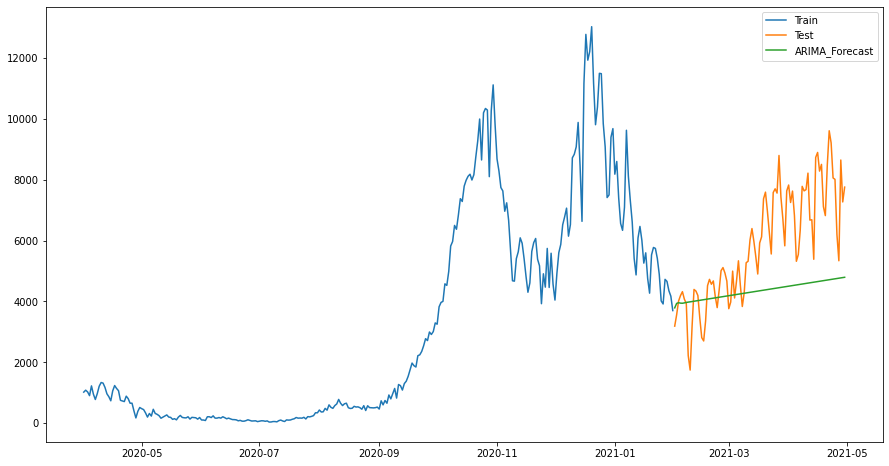

In [20]:
# Forecasting plot
# Code of ARIMA model plot modified from source: 
# https://www.analyticsvidhya.com/blog/2018/02/time-series-forecasting-methods/?#

plt.figure(figsize=(15,8))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(predictions, label='ARIMA_Forecast')
plt.legend(loc='best')
plt.show()

### Residuals analysis

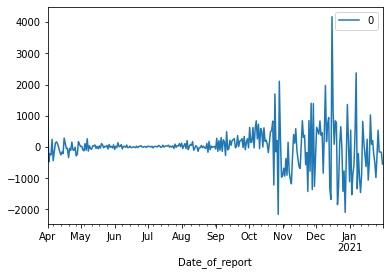

In [21]:
# line plot of residuals
residuals = DataFrame(model.resid)
residuals.plot()
plt.show()

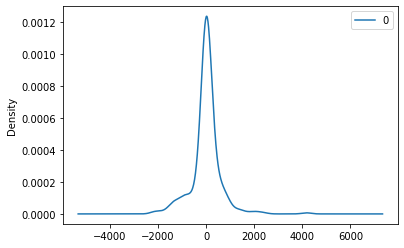

In [22]:
# density plot of residuals
residuals.plot(kind='kde')
plt.show()

In [23]:
# summary stats of residuals
print(residuals.describe())

                 0
count   306.000000
mean      1.107975
std     608.267355
min   -2159.508491
25%    -103.320239
50%      12.644689
75%     162.398471
max    4170.348669


## ARIMA model, performance metrics

In [24]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt


In [25]:
rmse = sqrt(mean_squared_error(test, predictions))
print(rmse)


2172.8765846426463


In [26]:
mae = mean_absolute_error(test, predictions)
print(mae)


1721.4173192605206


END OF NOTEBOOK, VERSION 27TH JUNE 2021. TIME SERIES MODELLING 2 